# Data description

The data consists of 1567 examples each with 591 features.
The dataset presented in this case represents a selection of such features where each example represents a single production entity with
associated measured features and the labels represent a simple pass/fail yield for in house line testing. Target column “ –1” corresponds to
a pass and “1” corresponds to a fail and the data time stamp is for that specific test point.

# Prediction objective 

 We will build a classifier to predict the Pass/Fail yield of a particular process entity and analyse whether all the
features are required to build the model or not.

# Import the Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB as gnb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import tree
from os import system
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

# Load the dataset

In [2]:
#importing csv data and view data
data=pd.read_csv("signal-data.csv")
data.head()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


# Exploratory data analysis

In [3]:
#chec
data.shape

(1567, 592)

In [4]:
data.dtypes

Time          object
0            float64
1            float64
2            float64
3            float64
              ...   
586          float64
587          float64
588          float64
589          float64
Pass/Fail      int64
Length: 592, dtype: object

In [5]:
#checking blanks, there are no blanks in data
data.isnull().sum()

Time          0
0             6
1             7
2            14
3            14
             ..
586           1
587           1
588           1
589           1
Pass/Fail     0
Length: 592, dtype: int64

In [6]:
#Moving status column to the last
df=data.pop('Pass/Fail') 
data['Pass/Fail'] = df

In [7]:
# Replacing all the NaN values with 0 as the values correspond to the test results.
# since, the values are not present that means the values are not available or calculated
# so better we not take median or mean and replace them with zeros

data = data.replace(np.NaN, 0)

# again, checking if there is any NULL values left
data.isnull().any().any()

False

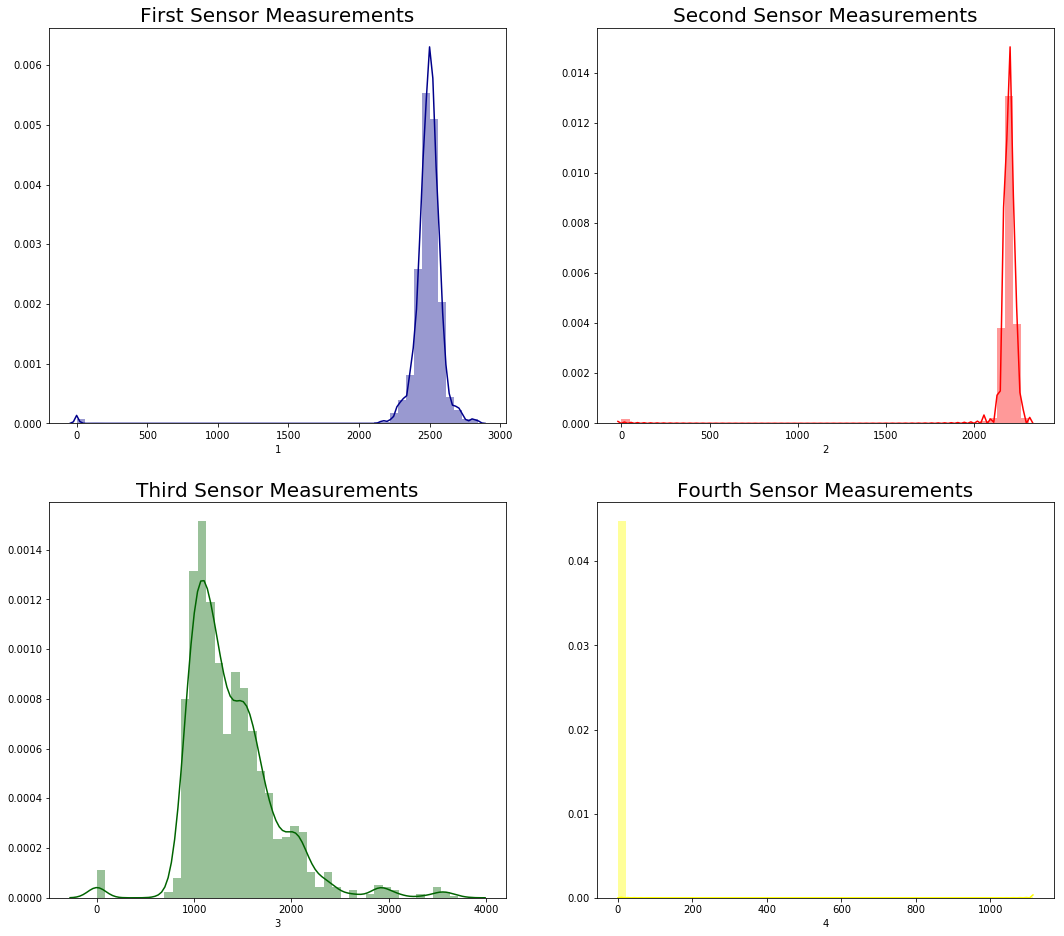

In [8]:
# distribution plot to see first four column's distribution

plt.rcParams['figure.figsize'] = (18, 16)

plt.subplot(2, 2, 1)
sns.distplot(data['1'], color = 'darkblue')
plt.title('First Sensor Measurements', fontsize = 20)

plt.subplot(2, 2, 2)
sns.distplot(data['2'], color = 'red')
plt.title('Second Sensor Measurements', fontsize = 20)

plt.subplot(2, 2, 3)
sns.distplot(data['3'], color = 'darkgreen')
plt.title('Third Sensor Measurements', fontsize = 20)

plt.subplot(2, 2, 4)
sns.distplot(data['4'], color = 'yellow')
plt.title('Fourth Sensor Measurements', fontsize = 20)

plt.show()


# Checking for data imbalance

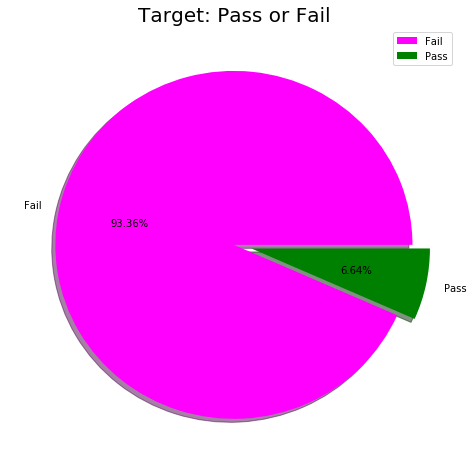

In [9]:
# pie chart

labels = ['Fail', 'Pass']
size = data['Pass/Fail'].value_counts()
colors = ['magenta', 'green']
explode = [0, 0.1]

plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, labels =labels, colors = colors, explode = explode, autopct = "%.2f%%", shadow = True)
plt.axis('off')
plt.title('Target: Pass or Fail', fontsize = 20)
plt.legend()
plt.show()


In [10]:
data['Pass/Fail'].value_counts(dropna=False)

-1    1463
 1     104
Name: Pass/Fail, dtype: int64

# Clearly, we can infer that the target column is imbalanced

Text(0.5,1,'Heatmap for the Data')

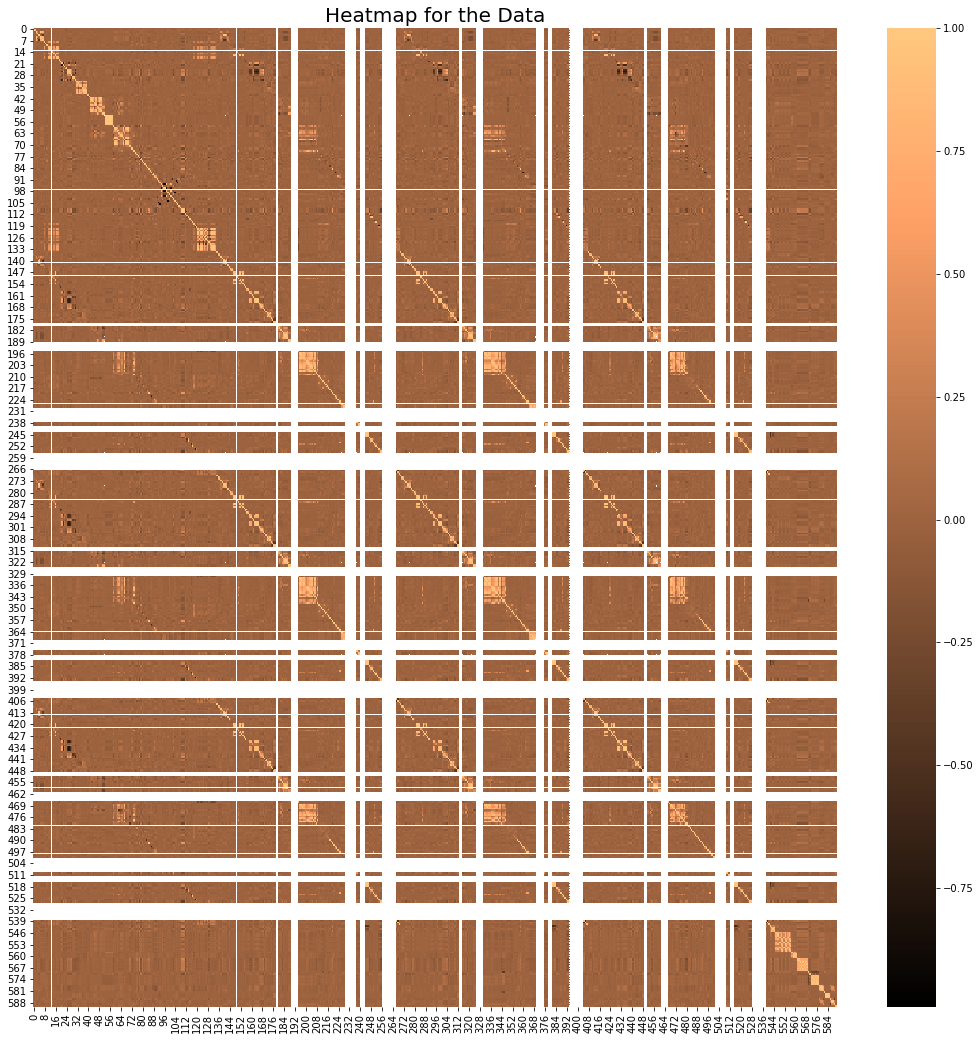

In [11]:
# heatmap

plt.rcParams['figure.figsize'] = (18, 18)
sns.heatmap(data.corr(), cmap = 'copper')
plt.title('Heatmap for the Data', fontsize = 20)

# Data Preprocessing

In [12]:
# deleting the first column

data = data.drop(columns = ['Time'], axis = 1)

# checking the shape of the data after deleting a column
data.shape

(1567, 591)

In [13]:
# separating the dependent and independent data

x = data.iloc[:,:590]
y = data.iloc[:, 590]

# getting the shapes of new data sets x and y
print("shape of x:", x.shape)
print("shape of y:", y.shape)


shape of x: (1567, 590)
shape of y: (1567,)


In [14]:
# splitting them into train test and split

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

# gettiing the shapes
print("shape of x_train: ", x_train.shape)
print("shape of x_test: ", x_test.shape)
print("shape of y_train: ", y_train.shape)
print("shape of y_test: ", y_test.shape)

shape of x_train:  (1253, 590)
shape of x_test:  (314, 590)
shape of y_train:  (1253,)
shape of y_test:  (314,)


In [15]:
# standardization

from sklearn.preprocessing import StandardScaler

# creating a standard scaler
sc = StandardScaler()

# fitting independent data to the model
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# UnderSamling of the Dataset

Undersampling refers to a group of techniques designed to balance the class distribution for a classification dataset that has a skewed class distribution.

An imbalanced class distribution will have one or more classes with few examples (the minority classes) and one or more classes with many examples (the majority classes). It is best understood in the context of a binary (two-class) classification problem where class 0 is the majority class and class 1 is the minority class.

Undersampling techniques remove examples from the training dataset that belong to the majority class in order to better balance the class distribution, such as reducing the skew from a 1:100 to a 1:10, 1:2, or even a 1:1 class distribution. This is different from oversampling that involves adding examples to the minority class in an effort to reduce the skew in the class distribution.

In [16]:
# Under Sampling
failed_tests = np.array(data[data['Pass/Fail'] == 1].index)
no_failed_tests = len(failed_tests)
print(no_failed_tests)

104


In [17]:
normal_indices = data[data['Pass/Fail'] == -1]
no_normal_indices = len(normal_indices)
print(no_normal_indices)

1463


In [18]:
random_normal_indices = np.random.choice(no_normal_indices, size = no_failed_tests, replace = True)
random_normal_indices = np.array(random_normal_indices)
print(len(random_normal_indices))

104


In [19]:
under_sample = np.concatenate([failed_tests, random_normal_indices])
print(len(under_sample))

208


In [20]:
# creating the undersample data
undersample_data = data.iloc[under_sample, :]

# Data after the undersampling process

In [21]:
undersample_data['Pass/Fail'].value_counts(dropna=False)

 1    111
-1     97
Name: Pass/Fail, dtype: int64

In [22]:
# splitting the undersample dataset into x and y sets

x = undersample_data.iloc[:, undersample_data.columns != 'Pass/Fail'] 
y = undersample_data.iloc[:, undersample_data.columns == 'Pass/Fail']

print(x.shape)
print(y.shape)

(208, 590)
(208, 1)


In [23]:
from sklearn.model_selection import train_test_split
x_train_us, x_test_us, y_train_us, y_test_us = train_test_split(x, y, test_size = 0.2, random_state = 0)
print(x_train_us.shape)
print(y_train_us.shape)
print(x_test_us.shape)
print(y_test_us.shape)

(166, 590)
(166, 1)
(42, 590)
(42, 1)


In [24]:
# standardization
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train_us)
x_test = sc.transform(x_test_us)

# Random forest classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier 
model = RandomForestClassifier()
model.fit(x_train_us, y_train_us)
y_pred = model.predict(x_test_us)

# Using k fold cross validation in Random forest classifier

In [26]:
#Build the model with the best hyper parameters
scores = cross_val_score(model, x_train_us, y_train_us, cv=10)
print(scores)
print(np.mean(scores))

[0.70588235 0.76470588 0.76470588 0.64705882 0.70588235 0.58823529
 0.625      0.6875     0.625      0.8125    ]
0.6926470588235294


# Hyper parameter tuning using Grid search method

In [27]:
#Applying Grid Search CV to find the best model with the best parameters
from sklearn.model_selection import GridSearchCV
parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6]}]
grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy', cv = 2, n_jobs = -1)
grid_search = grid_search.fit(x_train_us, y_train_us)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

In [28]:
print("Best Accuracy: ", best_accuracy)
print("Best Parameter: ", best_parameters)

Best Accuracy:  0.6686746987951807
Best Parameter:  {'max_depth': 3}


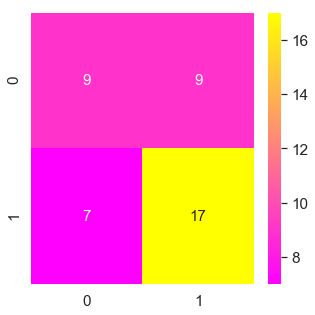

In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_us, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15}, cmap = 'spring')

In [30]:
TP=cm[0,0]
TN=cm[1,1]
FP=cm[0,1]
FN=cm[1,0]
acc1 = (TP+TN) / (TP+TN+FP+FN)
print("Accuracy of the random forest classifier",acc1)

Accuracy of the random forest classifier 0.6190476190476191


# Logistic regression

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression()
logreg.fit(x_train_us, y_train_us)
y_pred = logreg.predict(x_test_us)

# Using k fold cross validation in Logistic regression

In [32]:
#Build the model with the best hyper parameters
scores = cross_val_score(logreg, x_train_us, y_train_us, cv=10)
print(scores)
print(np.mean(scores))

[0.58823529 0.41176471 0.41176471 0.47058824 0.64705882 0.35294118
 0.625      0.5625     0.5625     0.5       ]
0.5132352941176471


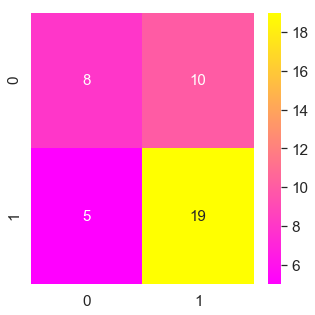

In [33]:
cm = confusion_matrix(y_test_us, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15}, cmap = 'spring')

In [34]:
TP=cm[0,0]
TN=cm[1,1]
FP=cm[0,1]
FN=cm[1,0]
acc2 = (TP+TN) / (TP+TN+FP+FN)
print("Accuracy of the logistic regression classifier",acc2)

Accuracy of the logistic regression classifier 0.6428571428571429


# Naive bayes

In [35]:
from sklearn.naive_bayes import GaussianNB
GNB1 = GaussianNB()
GNB1.fit(x_train_us, y_train_us)
y_pred = GNB1.predict(x_test_us)

# Using k fold cross validation in Naive bayes

In [36]:
#Build the model with the best hyper parameters
scores = cross_val_score(GNB1, x_train_us, y_train_us, cv=10)
print(scores)
print(np.mean(scores))

[0.58823529 0.47058824 0.47058824 0.47058824 0.52941176 0.52941176
 0.5        0.5625     0.625      0.4375    ]
0.5183823529411764


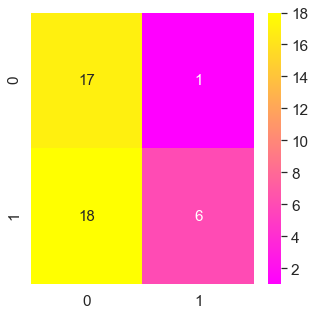

In [37]:
cm = confusion_matrix(y_test_us, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15}, cmap = 'spring')

In [38]:
TP=cm[0,0]
TN=cm[1,1]
FP=cm[0,1]
FN=cm[1,0]
acc3 = (TP+TN) / (TP+TN+FP+FN)
print("Accuracy of the naive bayes classifier",acc3)

Accuracy of the naive bayes classifier 0.5476190476190477


# Result (Selection of best model)

In [39]:
print("Accuracy of the random forest algorithm",acc1)
print("Accuracy of the logistic algorithm",acc2)
print("Accuracy of the naive bayes algorithm",acc3)

Accuracy of the random forest algorithm 0.6190476190476191
Accuracy of the logistic algorithm 0.6428571428571429
Accuracy of the naive bayes algorithm 0.5476190476190477


In [40]:
if(acc1>= acc2 and acc1>=acc3):
    print("Clearly, random forest is the best performing model")
if(acc2>= acc1 and acc2>=acc3):
    print("Clearly, logistic regression is the best performing model")
if(acc3>= acc1 and acc3>=acc2):
    print("Clearly, naive bayes is the best performing model")

Clearly, logistic regression is the best performing model
